# Neural network filters

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## I. Filters on a toy dataset

### 1. Dataset

In [2]:
batch_size = 32
epochs = 30
IMG_HEIGHT = 150
IMG_WIDTH = 150
KERNEL_SIZE = 3

In [3]:
class ImageDataset(Dataset):
    
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.files = [os.path.join("cat", file) for file in os.listdir(os.path.join(self.directory, "cat")) if "jpg" in file] + \
                     [os.path.join("dog", file) for file in os.listdir(os.path.join(self.directory, "dog")) if "jpg" in file]
        self.transform = transform
        print("Found {} images".format(len(self.files)))
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.directory, self.files[idx])
        image = load_img(img_name, target_size=(150, 150))
        image = img_to_array(image)
        
        if self.transform:
            image = self.transform(image)
          
        label = [0]
        if "dog" in img_name:
            label = [1]
        
        image = torch.Tensor(image)
        label = torch.Tensor(label).long()
        
        return image, label

Found 202 images


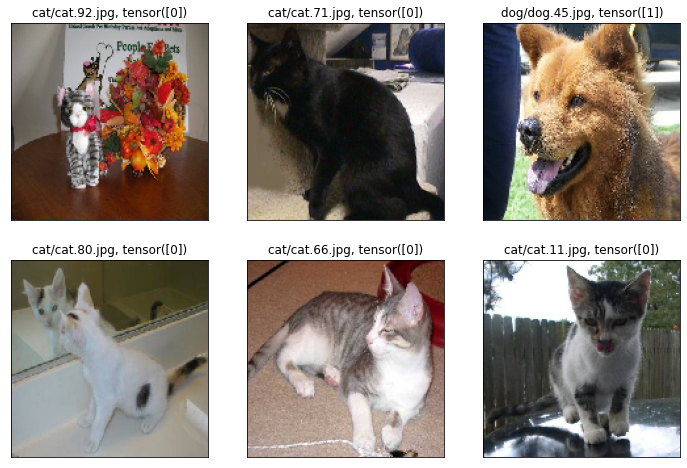

In [8]:
image_dataset = ImageDataset("dataset/min/train/")
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for i, index in enumerate(np.random.randint(len(image_dataset.files), size=6)):
    sample, label = image_dataset[index]
    sample = np.clip(sample.numpy(), 0, 255).astype('uint8')
    ax[i//3,i%3].imshow(sample)
    ax[i//3,i%3].set_title("{}, {}".format(image_dataset.files[index], label))
    ax[i//3,i%3].set_xticks([])
    ax[i//3,i%3].set_yticks([])

### 2. Dense network

In [5]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(IMG_HEIGHT*IMG_WIDTH*3, 2048),
    nn.ReLU(),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 2)
)

image_loader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [6]:
for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    batch_count = 0
    for batch, labels in image_loader:
        optimizer.zero_grad()
        
        outputs = model(batch)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        accuracy = ((predicted == labels.squeeze()).sum() / labels.size(0))
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
        batch_count += 1
    print("Epoch %d/%d   -   Loss: %.3f, accuracy: %.5f" % (epoch + 1,
                                                            epochs,
                                                            epoch_loss / batch_count,
                                                            epoch_accuracy / batch_count))
    epoch_loss = 0.0
    epoch_accuracy = 0.0

print("Finished training")        

Epoch 1/30   -   Loss: 1657.683, accuracy: 0.52589
Epoch 2/30   -   Loss: 645.356, accuracy: 0.45536
Epoch 3/30   -   Loss: 129.590, accuracy: 0.51786
Epoch 4/30   -   Loss: 58.069, accuracy: 0.48036
Epoch 5/30   -   Loss: 50.691, accuracy: 0.49911
Epoch 6/30   -   Loss: 6.611, accuracy: 0.54018
Epoch 7/30   -   Loss: 5.782, accuracy: 0.47321
Epoch 8/30   -   Loss: 4.229, accuracy: 0.44375
Epoch 9/30   -   Loss: 1.208, accuracy: 0.54375
Epoch 10/30   -   Loss: 0.815, accuracy: 0.66071
Epoch 11/30   -   Loss: 0.748, accuracy: 0.60625
Epoch 12/30   -   Loss: 1.301, accuracy: 0.51964
Epoch 13/30   -   Loss: 0.925, accuracy: 0.61875
Epoch 14/30   -   Loss: 0.633, accuracy: 0.69732
Epoch 15/30   -   Loss: 1.063, accuracy: 0.62589
Epoch 16/30   -   Loss: 0.647, accuracy: 0.70446
Epoch 17/30   -   Loss: 0.967, accuracy: 0.63482
Epoch 18/30   -   Loss: 0.432, accuracy: 0.82589
Epoch 19/30   -   Loss: 0.901, accuracy: 0.73214
Epoch 20/30   -   Loss: 0.832, accuracy: 0.70536
Epoch 21/30   -   Lo

### 2.1. Filters

(2048, 67500)


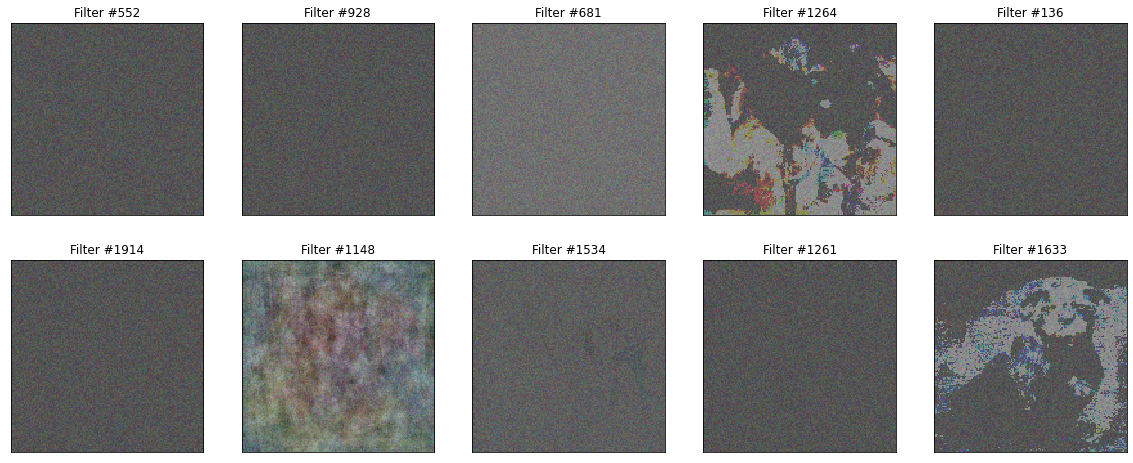

In [7]:
NB_FIGURES = 10
NB_ROWS = 2
NB_COLUMNS = 5

layer = model[1]
weights = layer.weight.detach().numpy()

print(weights.shape)

# normalize
f_min, f_max = weights.min(), weights.max()
filters = (weights - f_min) / (f_max - f_min)

# plot
indices = np.random.randint(filters.shape[0], size=NB_FIGURES)
fig, ax = plt.subplots(NB_ROWS, NB_COLUMNS, figsize=(20, 8))
for i in range(NB_FIGURES):
    filt = filters[indices[i], :].reshape(IMG_HEIGHT, IMG_WIDTH, 3)
    ax[i//NB_COLUMNS, i%NB_COLUMNS].imshow(filt, interpolation='nearest', cmap='bone')
    ax[i//NB_COLUMNS, i%NB_COLUMNS].set_title("Filter #{}".format(indices[i]))
    ax[i//NB_COLUMNS, i%NB_COLUMNS].set_xticks([])
    ax[i//NB_COLUMNS, i%NB_COLUMNS].set_yticks([])

### 3. Convolutional network

In [9]:
model = nn.Sequential(
    nn.Conv2d(3, 16, KERNEL_SIZE, padding=KERNEL_SIZE//2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),
    nn.Conv2d(16, 32, KERNEL_SIZE, padding=KERNEL_SIZE//2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, KERNEL_SIZE, padding=KERNEL_SIZE//2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),
    nn.Flatten(),
    nn.Linear(20736 ,512),
    nn.ReLU(),
    nn.Linear(512, 2)
)

image_loader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [10]:
for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    batch_count = 0
    for batch, labels in image_loader:
        optimizer.zero_grad()
        batch = batch.transpose(1, 3).transpose(2, 3)
        
        outputs = model(batch)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        accuracy = ((predicted == labels.squeeze()).sum() / labels.size(0))
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
        batch_count += 1
    print("Epoch %d/%d   -   Loss: %.3f, accuracy: %.5f" % (epoch + 1,
                                                            epochs,
                                                            epoch_loss / batch_count,
                                                            epoch_accuracy / batch_count))
    epoch_loss = 0.0
    epoch_accuracy = 0.0

print("Finished training")   

Epoch 1/30   -   Loss: 56.797, accuracy: 0.56071
Epoch 2/30   -   Loss: 1.031, accuracy: 0.50089
Epoch 3/30   -   Loss: 0.685, accuracy: 0.53839
Epoch 4/30   -   Loss: 0.651, accuracy: 0.64464
Epoch 5/30   -   Loss: 0.549, accuracy: 0.73839
Epoch 6/30   -   Loss: 0.540, accuracy: 0.72500
Epoch 7/30   -   Loss: 0.458, accuracy: 0.79196
Epoch 8/30   -   Loss: 0.385, accuracy: 0.83661
Epoch 9/30   -   Loss: 0.319, accuracy: 0.85893
Epoch 10/30   -   Loss: 0.282, accuracy: 0.85893
Epoch 11/30   -   Loss: 0.161, accuracy: 0.94107
Epoch 12/30   -   Loss: 0.157, accuracy: 0.93661
Epoch 13/30   -   Loss: 0.132, accuracy: 0.97321
Epoch 14/30   -   Loss: 0.136, accuracy: 0.96429
Epoch 15/30   -   Loss: 0.108, accuracy: 0.97321
Epoch 16/30   -   Loss: 0.101, accuracy: 0.96429
Epoch 17/30   -   Loss: 0.103, accuracy: 0.95000
Epoch 18/30   -   Loss: 0.031, accuracy: 1.00000
Epoch 19/30   -   Loss: 0.047, accuracy: 0.97232
Epoch 20/30   -   Loss: 0.081, accuracy: 0.97321
Epoch 21/30   -   Loss: 0.15

### 3.1. Filters

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([16, 3, 3, 3])
16


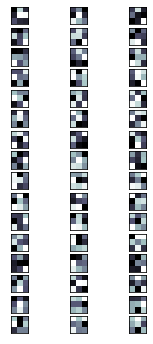

Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([32, 16, 3, 3])
32


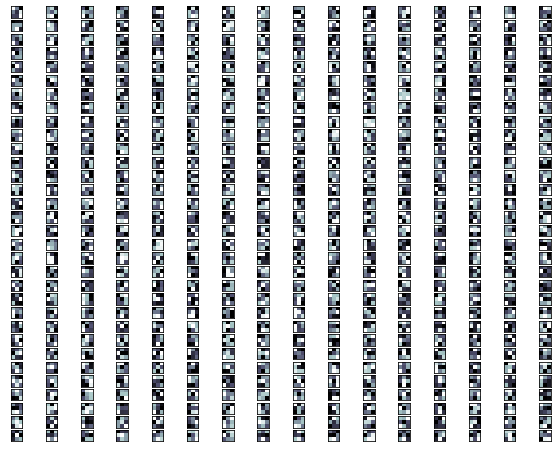

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([64, 32, 3, 3])
64


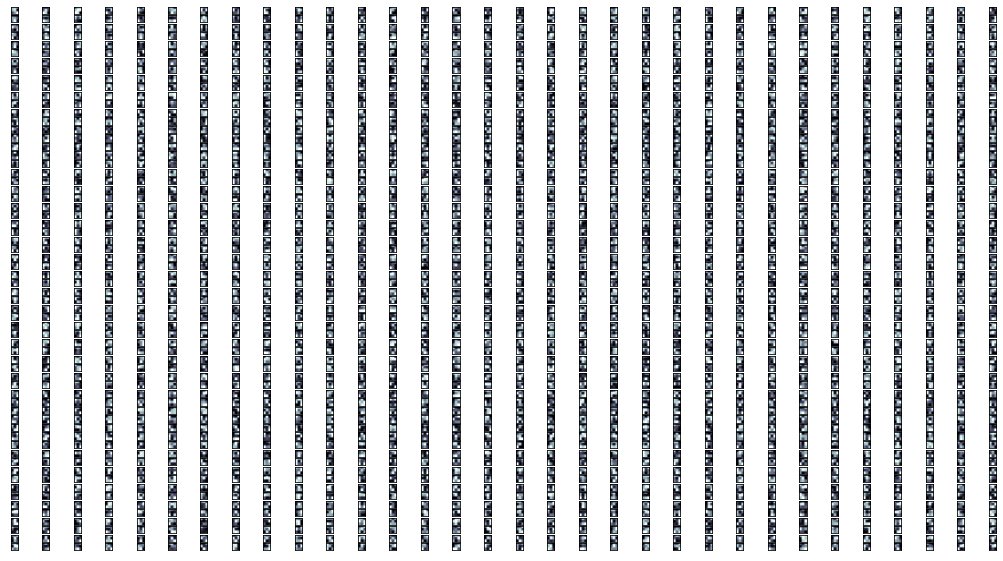

In [11]:
figsizes = [(3, 6), (10, 8), (18, 10)]

count = 0
for layer in model:
    if isinstance(layer, nn.Conv2d):
        weights = layer.weight.data
        print(layer, weights.shape)
        
        # normalize
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)
        print(filters.shape[0])
        filter_cnt=1
        
        # plot
        fig, ax = plt.subplots(filters.shape[0], filters.shape[1], figsize=figsizes[count])
        for i in range(filters.shape[0]):
            filt = filters[i, :, :,:]
            for k in range(filt.shape[0]):
                ax[i, k].imshow(filt[k, :, :], cmap="bone")
                ax[i, k].set_xticks([])
                ax[i, k].set_yticks([])
        plt.show()
        count += 1

### 3.2. Feature maps

Let's visualize the feature map from this image:  
![dog](dataset/min/train/dog/dog.67.jpg)

(1, 3, 150, 150)
(1, 16, 150, 150)
(1, 16, 150, 150)
(1, 16, 75, 75)
(1, 16, 75, 75)
(1, 32, 75, 75)
(1, 32, 75, 75)
(1, 32, 37, 37)
(1, 64, 37, 37)
(1, 64, 37, 37)
(1, 64, 18, 18)
(1, 64, 18, 18)


<ipython-input-13-47b3192d2981>:26: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


(1, 20736)
(1, 512)
(1, 512)
(1, 2)


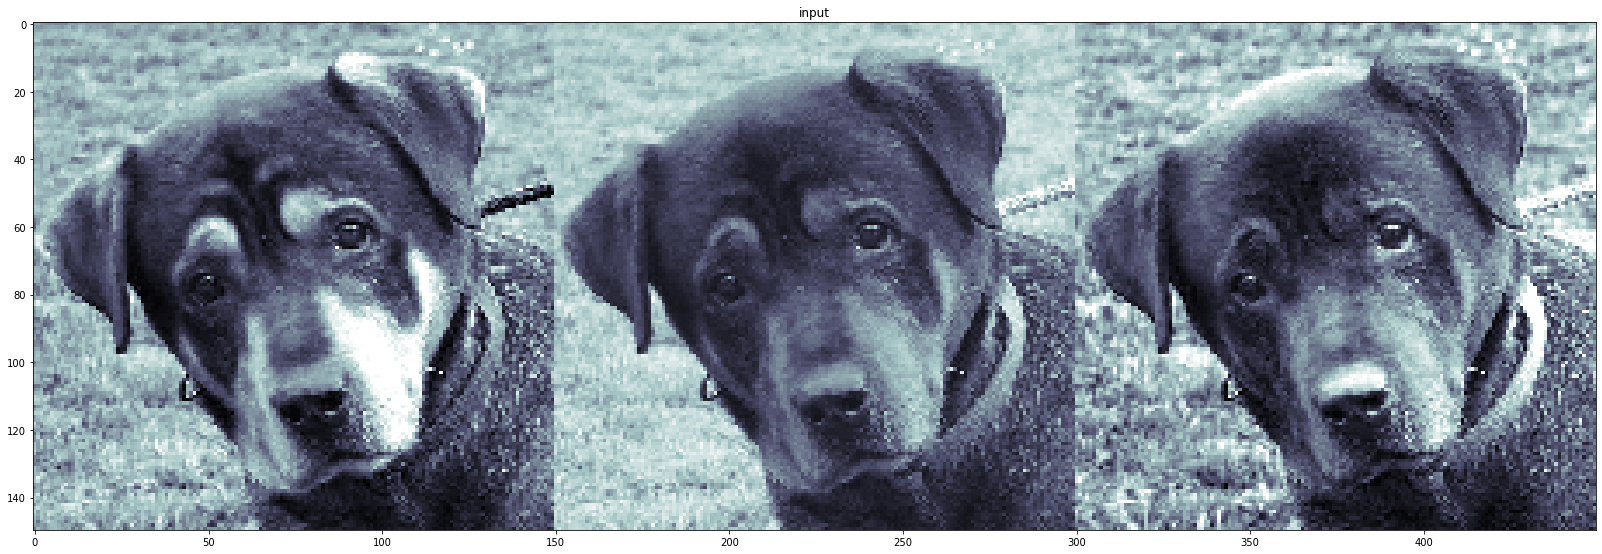

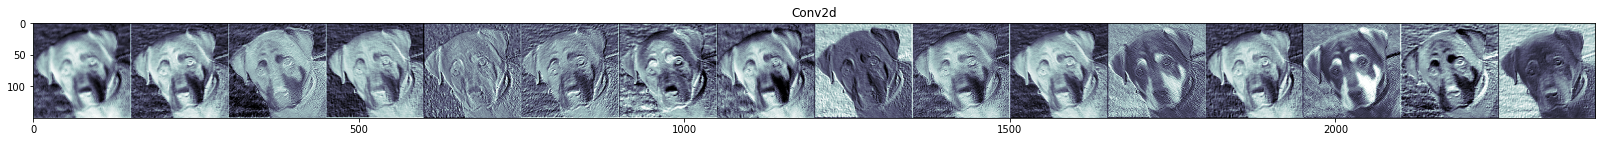

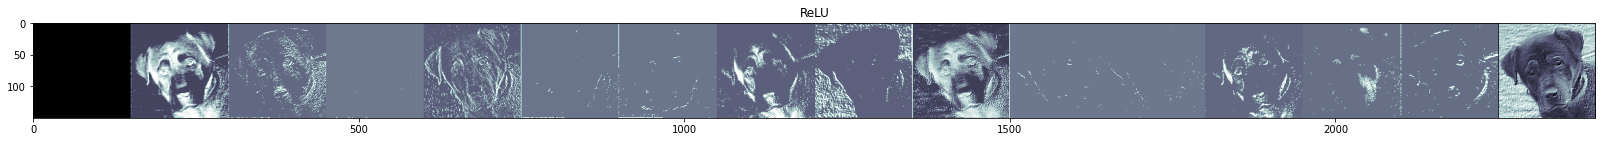

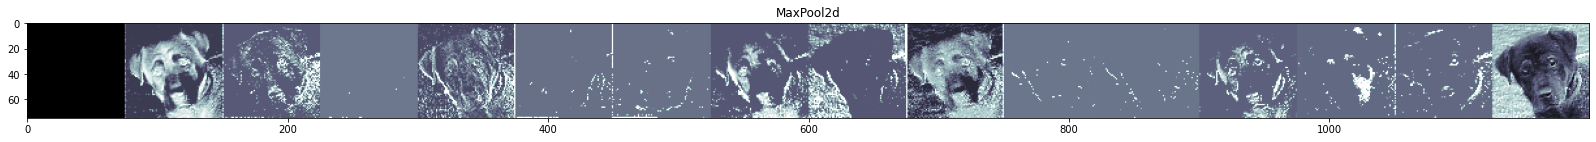

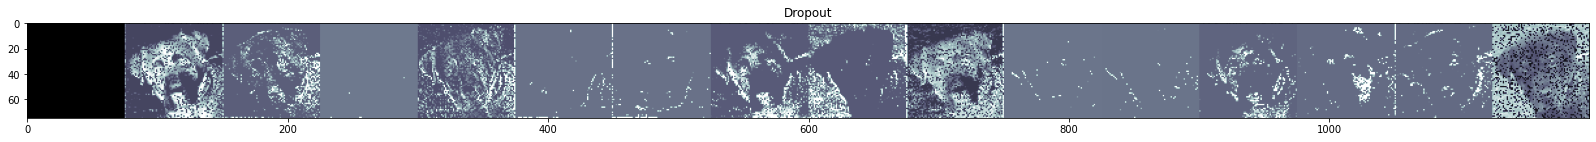

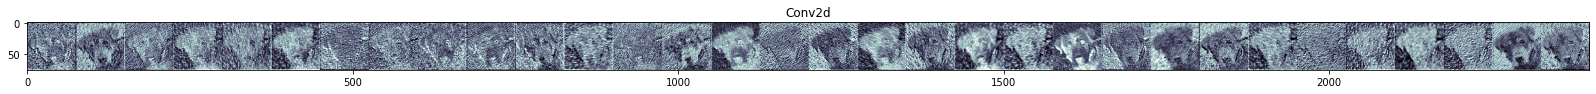

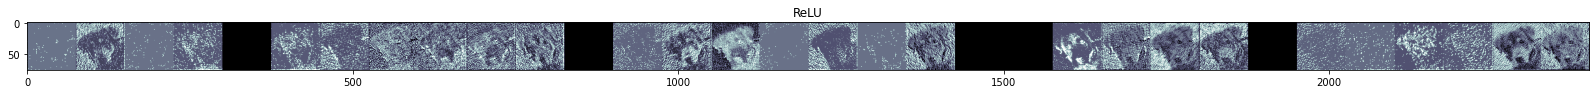

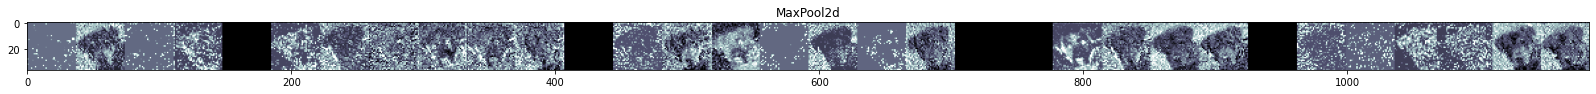

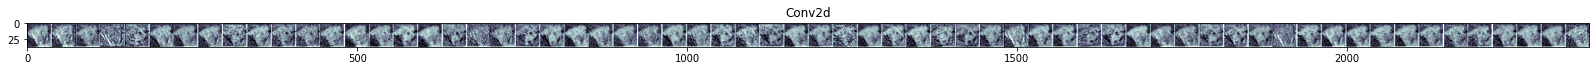

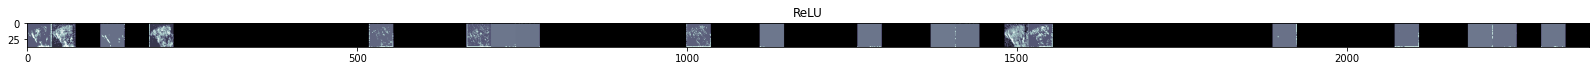

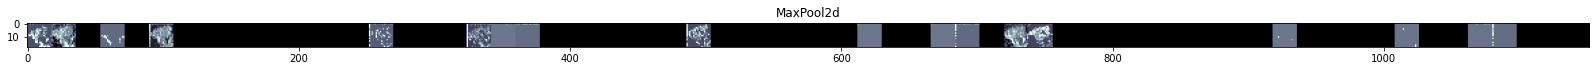

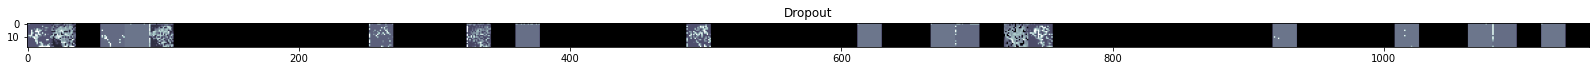

In [13]:
img_path = "dataset/min/train/dog/dog.67.jpg"

img = load_img(img_path, target_size=(150, 150))

x = img_to_array(img)
x /= 255.
x = x.reshape((1,) + x.shape)
x = torch.Tensor(x)
x = x.transpose(1, 3).transpose(2, 3)

outputs = [(model[i]._get_name(), model[:i+1]) for i in range(len(model))]

feature_maps = [('input', x)] + [(layer_name, layer(x)) for layer_name, layer in outputs]
for f_name, f_map in feature_maps:
    f_map = f_map.data.numpy()
    print(f_map.shape)
    
    if len(f_map.shape) == 4:
        n_features = f_map.shape[1]
        size = f_map.shape[2]
        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            x = f_map[0, i, :, :]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i+1) * size] = x

        scale = 28. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(f_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='bone')

## II. VGG16 filters

In [14]:
from torchvision.models import vgg16

vgg_model = torchvision.models.vgg16(pretrained=True, progress=True)

vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 1. Filters

### 2. Feature maps

(1, 3, 224, 224)
(1, 64, 224, 224)
(1, 64, 224, 224)
(1, 64, 224, 224)
(1, 64, 224, 224)


<ipython-input-15-33bed07997ab>:30: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


(1, 64, 112, 112)
(1, 128, 112, 112)
(1, 128, 112, 112)
(1, 128, 112, 112)
(1, 128, 112, 112)
(1, 128, 56, 56)
(1, 256, 56, 56)
(1, 256, 56, 56)
(1, 256, 56, 56)
(1, 256, 56, 56)
(1, 256, 56, 56)
(1, 256, 56, 56)
(1, 256, 28, 28)
(1, 512, 28, 28)
(1, 512, 28, 28)
(1, 512, 28, 28)
(1, 512, 28, 28)


<ipython-input-15-33bed07997ab>:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(scale * n_features, scale))


(1, 512, 28, 28)
(1, 512, 28, 28)
(1, 512, 14, 14)
(1, 512, 14, 14)
(1, 512, 14, 14)
(1, 512, 14, 14)
(1, 512, 14, 14)
(1, 512, 14, 14)
(1, 512, 14, 14)
(1, 512, 7, 7)


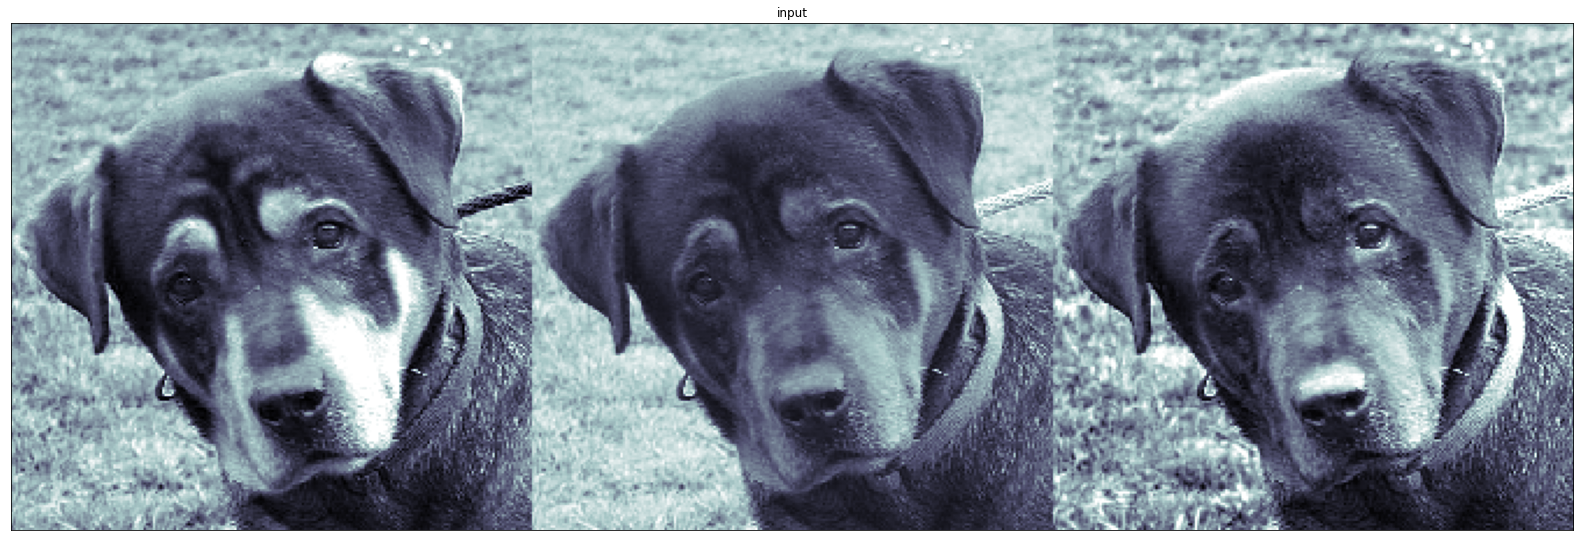

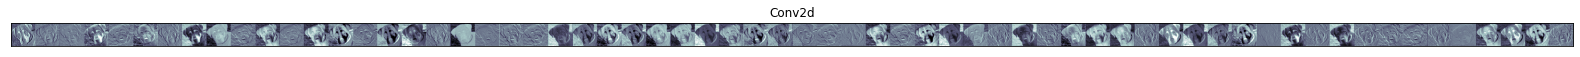

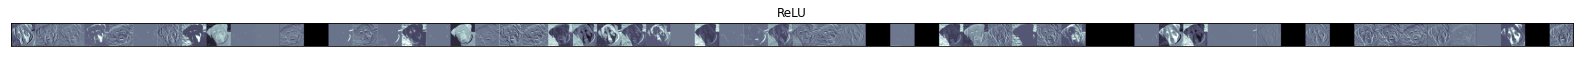

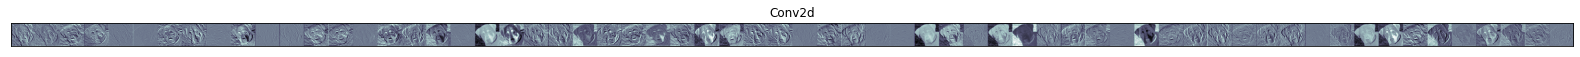

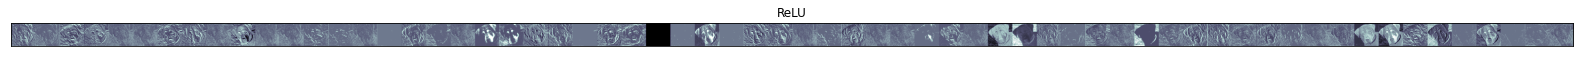

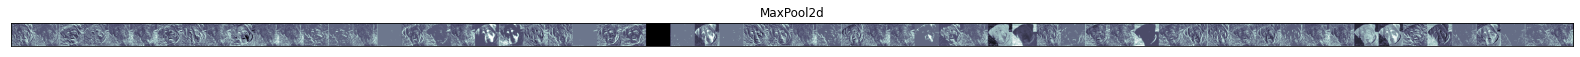

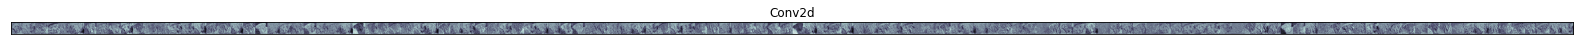

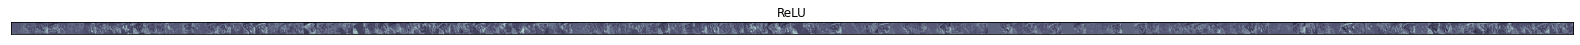

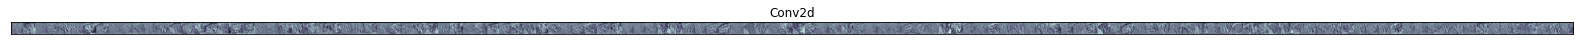

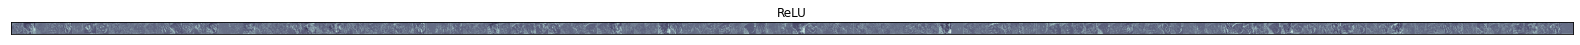

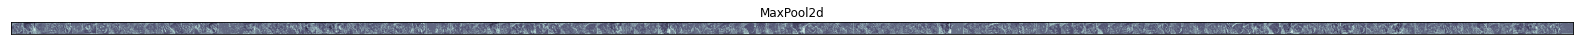

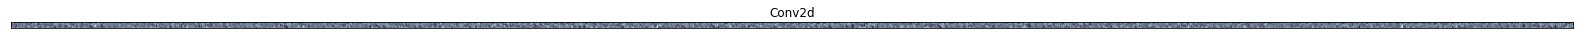

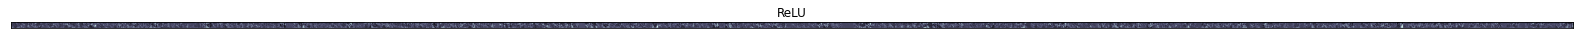

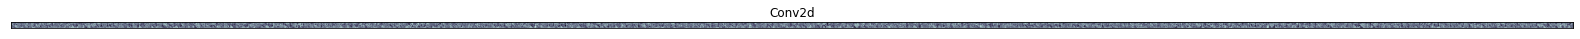

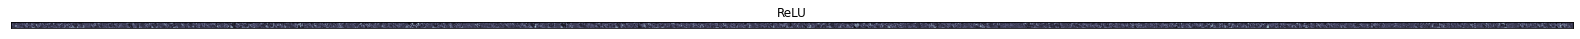

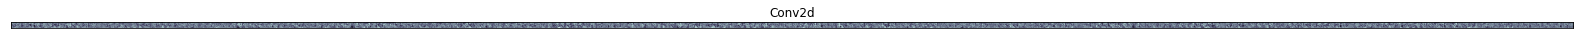

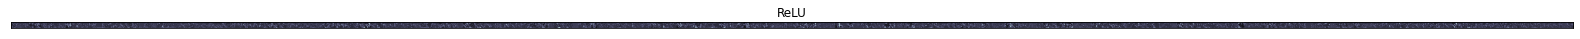

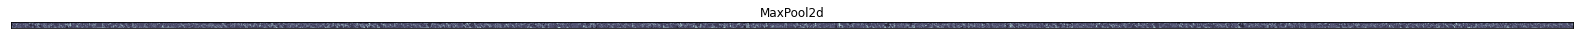

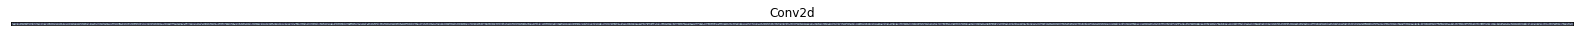

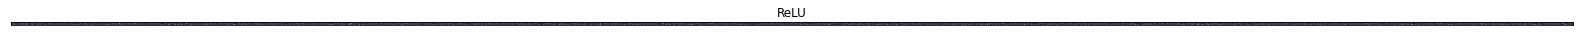

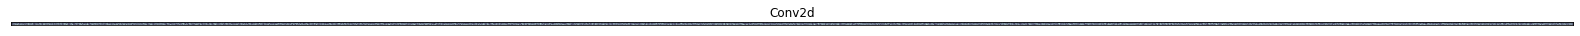

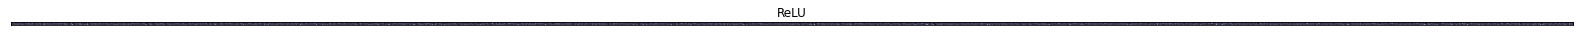

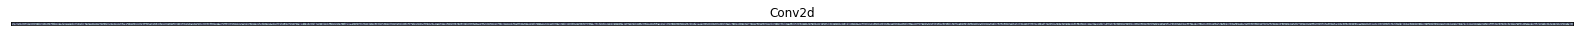

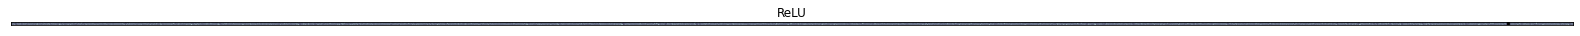

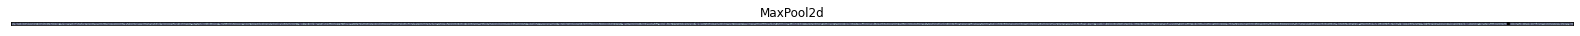

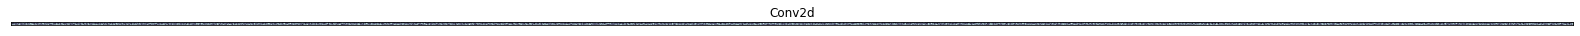

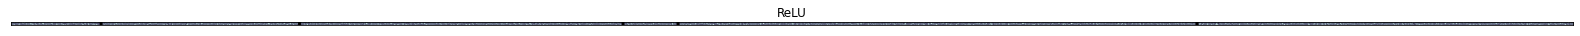

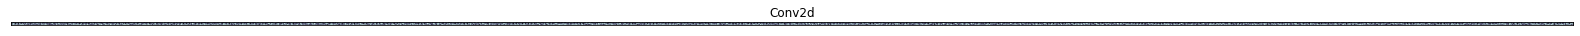

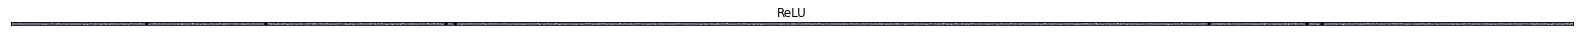

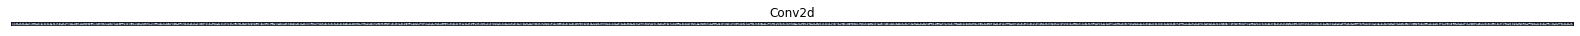

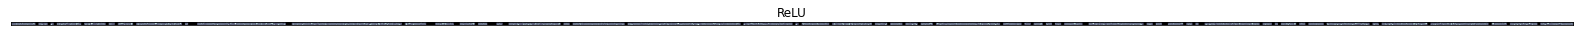

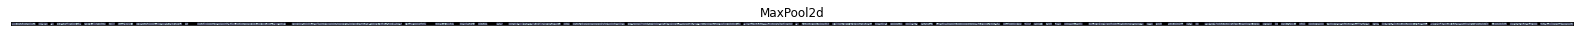

In [15]:
img_path = "dataset/min/train/dog/dog.67.jpg"

img = load_img(img_path, target_size=(224, 224))

x = img_to_array(img)
x /= 255.
x = x.reshape((1,) + x.shape)
x = torch.Tensor(x)
x = x.transpose(1, 3).transpose(2, 3)

outputs = [(vgg_model.features[i]._get_name(), vgg_model.features[:i+1]) for i in range(len(vgg_model.features)) 
           if isinstance(vgg_model.features[i], nn.Conv2d)
           or isinstance(vgg_model.features[i], nn.MaxPool2d)
           or isinstance(vgg_model.features[i], nn.Dropout)
           or isinstance(vgg_model.features[i], nn.ReLU)]

feature_maps = [('input', x)] + [(layer_name, layer(x)) for (layer_name, layer) in outputs]
for f_name, f_map in feature_maps:
    f_map = f_map.data.numpy()
    print(f_map.shape)
    
    if len(f_map.shape) == 4:
        n_features = f_map.shape[1]
        size = f_map.shape[2]
        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            x = f_map[0, i, :, :]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i+1) * size] = x

        scale = 28. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(f_name)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(display_grid, aspect='auto', cmap='bone')